In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
%matplotlib inline
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

#os.chdir('/content/drive/My Drive/GitHub Repositories/Tuberculosis/Tuberculosis Classification')

trainDir = '../data/Train'
validDir = '../data/Test'

IMG_SIZE = 512 # slightly smaller than vgg16 normally expects
datagen = ImageDataGenerator(rescale=1./255, 
                             samplewise_center=False, 
                             samplewise_std_normalization=False, 
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.15, 
                             width_shift_range = 0.15, 
                             rotation_range = 5, 
                             shear_range = 0.01,
                             fill_mode = 'nearest',
                             zoom_range=0.1,  
                             )

train_gen = datagen.flow_from_directory(
    directory=trainDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=2019)

valid_gen = datagen.flow_from_directory(
    directory=validDir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    seed=2019)




Using TensorFlow backend.


Found 721 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


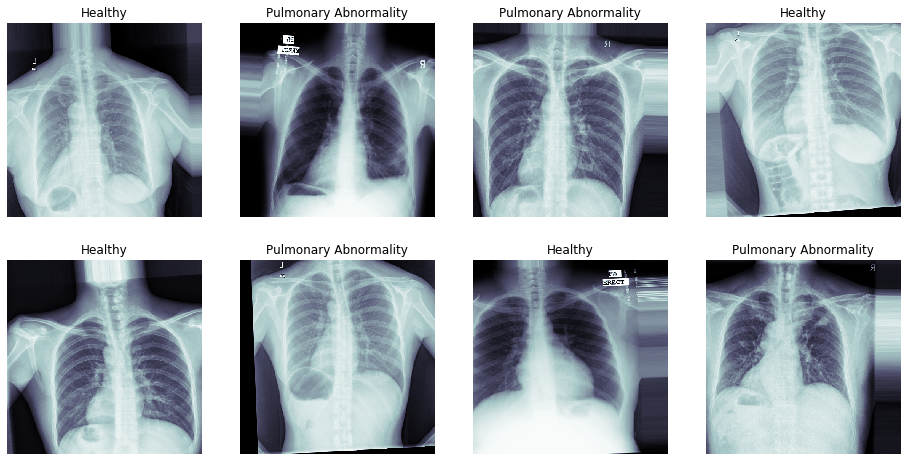

In [3]:
import matplotlib.pyplot as plt

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = 0, vmax = 1)
    c_ax.set_title('%s' % ('Pulmonary Abnormality' if np.argmax(c_y)>0.5 else 'Healthy'))
    c_ax.axis('off')


In [4]:
from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras.models import *
from keras.optimizers import *

IMG_SIZE = 512
img_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(img_shape)
num_classes = 2

vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape= img_shape)
vgg19_model.trainable = False
outputs = vgg19_model(inputs)
outputs = BatchNormalization(name = 'BatchNormalization')(outputs)
outputs = GlobalAveragePooling2D()(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(256)(outputs)
outputs = LeakyReLU(alpha=0.1)(outputs)
outputs = Dropout(0.25)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 16, 16, 512)       20024384  
_________________________________________________________________
BatchNormalization (BatchNor (None, 16, 16, 512)       2048      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_____________

In [5]:
from keras.callbacks import *

weight_path=os.path.join( '../Fine Tuning with VGG19', '{}_pretrainedvgg19model.bestweights.hdf5'.format('TB'))
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, save_best_only=True, mode='auto', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="'val_acc'", mode="auto", patience=30) 

callbacks_list = [checkpoint, early, reduceLROnPlat]

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
model.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_gen, validation_steps=STEP_SIZE_VALID,
                    epochs = 100, callbacks = callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Users\Zeeshan\Anaconda3\envs\tensorflow_1.15\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '




Epoch 1/100
45/45 [==============================] - 131s 3s/step - loss: 0.5699 - acc: 0.7485 - val_loss: 0.5259 - val_acc: 0.7969

Epoch 00001: val_acc improved from -inf to 0.79688, saving model to ../Fine Tuning with VGG19\TB_pretrainedvgg19model.bestweights.hdf5
Epoch 2/100

C:\Users\Zeeshan\Anaconda3\envs\tensorflow_1.15\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `'val_acc'` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



45/45 [==============================] - 130s 3s/step - loss: 0.5083 - acc: 0.7569 - val_loss: 0.6513 - val_acc: 0.6349

Epoch 00002: val_acc did not improve from 0.79688
Epoch 3/100
 1/45 [..............................] - ETA: 1s - loss: 0.7099 - acc: 0.0000e+00

C:\Users\Zeeshan\Anaconda3\envs\tensorflow_1.15\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `'val_acc'` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


45/45 [==============================] - 129s 3s/step - loss: 0.5048 - acc: 0.7573 - val_loss: 0.5951 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.79688
Epoch 4/100
45/45 [==============================] - 128s 3s/step - loss: 0.4751 - acc: 0.7684 - val_loss: 0.6283 - val_acc: 0.6825

Epoch 00004: val_acc did not improve from 0.79688
Epoch 5/100
45/45 [==============================] - 130s 3s/step - loss: 0.4596 - acc: 0.7777 - val_loss: 0.6362 - val_acc: 0.6667

Epoch 00005: val_acc did not improve from 0.79688
Epoch 6/100
45/45 [==============================] - 130s 3s/step - loss: 0.4547 - acc: 0.7985 - val_loss: 0.4495 - val_acc: 0.7969

Epoch 00006: val_acc did not improve from 0.79688
Epoch 7/100
45/45 [==============================] - 129s 3s/step - loss: 0.5122 - acc: 0.7434 - val_loss: 0.5589 - val_acc: 0.6825

Epoch 00007: val_acc did not improve from 0.79688
Epoch 8/100
45/45 [==============================] - 131s 3s/step - loss: 0.4554 - acc: 0.7846 - 

45/45 [==============================] - 125s 3s/step - loss: 0.4209 - acc: 0.7962 - val_loss: 0.3918 - val_acc: 0.8594

Epoch 00046: val_acc did not improve from 0.85938
Epoch 47/100
45/45 [==============================] - 125s 3s/step - loss: 0.3978 - acc: 0.8360 - val_loss: 0.4940 - val_acc: 0.7460

Epoch 00047: val_acc did not improve from 0.85938
Epoch 48/100
45/45 [==============================] - 128s 3s/step - loss: 0.4171 - acc: 0.8056 - val_loss: 0.6079 - val_acc: 0.7460

Epoch 00048: val_acc did not improve from 0.85938
Epoch 49/100
45/45 [==============================] - 125s 3s/step - loss: 0.4155 - acc: 0.8031 - val_loss: 0.5675 - val_acc: 0.7460

Epoch 00049: val_acc did not improve from 0.85938
Epoch 50/100
45/45 [==============================] - 124s 3s/step - loss: 0.4026 - acc: 0.8059 - val_loss: 0.5494 - val_acc: 0.7302

Epoch 00050: val_acc did not improve from 0.85938
Epoch 51/100
45/45 [==============================] - 125s 3s/step - loss: 0.3743 - acc: 0.83

45/45 [==============================] - 129s 3s/step - loss: 0.3757 - acc: 0.8541 - val_loss: 0.5301 - val_acc: 0.7778

Epoch 00089: val_acc did not improve from 0.90625
Epoch 90/100
45/45 [==============================] - 128s 3s/step - loss: 0.3767 - acc: 0.8226 - val_loss: 0.6159 - val_acc: 0.6508

Epoch 00090: val_acc did not improve from 0.90625
Epoch 91/100
45/45 [==============================] - 130s 3s/step - loss: 0.3737 - acc: 0.8296 - val_loss: 0.4132 - val_acc: 0.8438

Epoch 00091: val_acc did not improve from 0.90625
Epoch 92/100
45/45 [==============================] - 129s 3s/step - loss: 0.3928 - acc: 0.8115 - val_loss: 0.5248 - val_acc: 0.7460

Epoch 00092: val_acc did not improve from 0.90625
Epoch 93/100
45/45 [==============================] - 129s 3s/step - loss: 0.3744 - acc: 0.8184 - val_loss: 0.6450 - val_acc: 0.6984

Epoch 00093: val_acc did not improve from 0.90625
Epoch 94/100
45/45 [==============================] - 132s 3s/step - loss: 0.3581 - acc: 0.83